# Lecture 5.5 Master Equations

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib import cm

## Example 5.13 SIS Model
### Master Equation Approach

Here we want to code in the following master equation.  Note that we have to make exceptions for when n=0 and $n=n_{\text{max}}$.

$$
\frac{dP_n(t)}{dt}=-P_n(t)\left(\gamma n +\frac{\beta}{\kappa}n(\kappa-n) \right)+P_{n-1}(t)\frac{\beta}{\kappa}(n-1)(\kappa-n+1)+P_{n+1}(t)\gamma (n+1)
$$

Assuming that $\gamma=0.1$, $\beta=0.5$, and $\kappa=100$.

For this problem, there is a natural choice of $n_{max}=\kappa$.

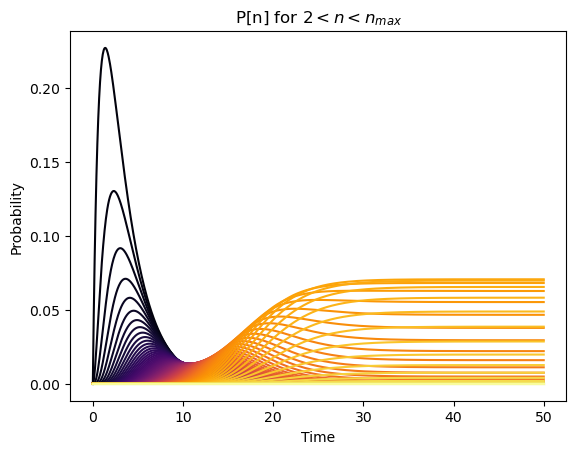

In [137]:
# Function defining the system of ODEs
def model(P, t, gamma, beta, kappa):
    dPdt = np.zeros_like(P)
    for n in range(len(P)):
        dPdt[n] = -P[n] * (gamma * n + beta / kappa * n * (kappa - n))
        if n>0:
            dPdt[n] +=P[n-1] * beta / kappa * (n-1) * (kappa -n+1)   
        if n<len(P)-1:
            dPdt[n] +=P[n+1] * gamma * (n+1)
    return dPdt
# Parameters
gamma = 0.1
beta = 0.5
kappa = 100.0

# Initial conditions
nMax=100; #Gives the # of equations
P0 = np.zeros(nMax)
P0[1] = 1.0  # Initial condition for P_0

# Time points for integration
t = np.linspace(0, 50, 1000)
deltat=20/1000

# Numerical integration using odeint
P_result = odeint(model, P0, t, args=(gamma, beta, kappa))

# Plotting the results

for i in range(2,nMax):
    plt.plot(t, P_result[:, i],color= cm.inferno(i/nMax))
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('P[n] for $2<n<n_{max}$')
plt.show()

The probability the disease goes extinct is given by the 0th element

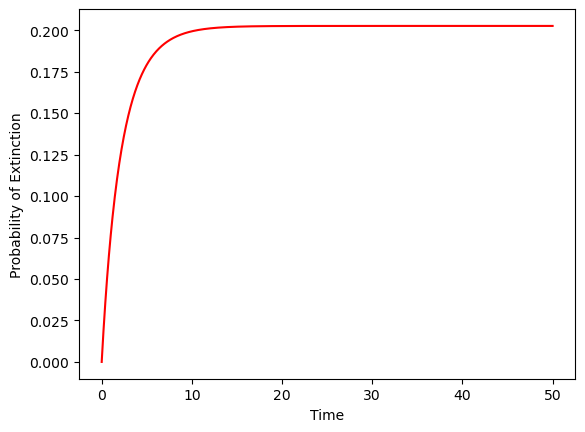

In [140]:
plt.plot(t, P_result[:, 0],color= 'red')
plt.xlabel('Time')
plt.ylabel('Probability of Extinction')
plt.show()

The probability that 1 individual is infected stats high (initial condition) and drops from there

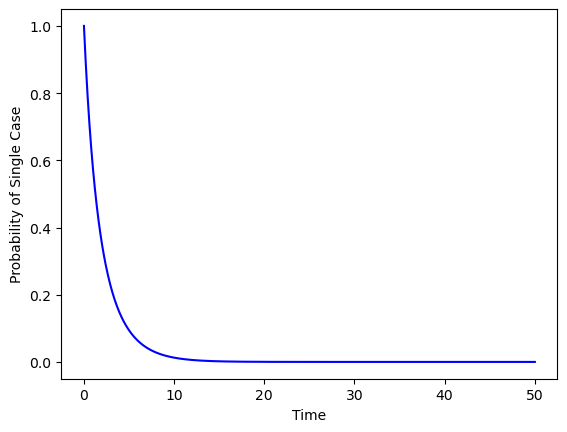

In [142]:
plt.plot(t, P_result[:, 1],color= 'blue')
plt.xlabel('Time')
plt.ylabel('Probability of Single Case')
plt.show()

### Simulation approach

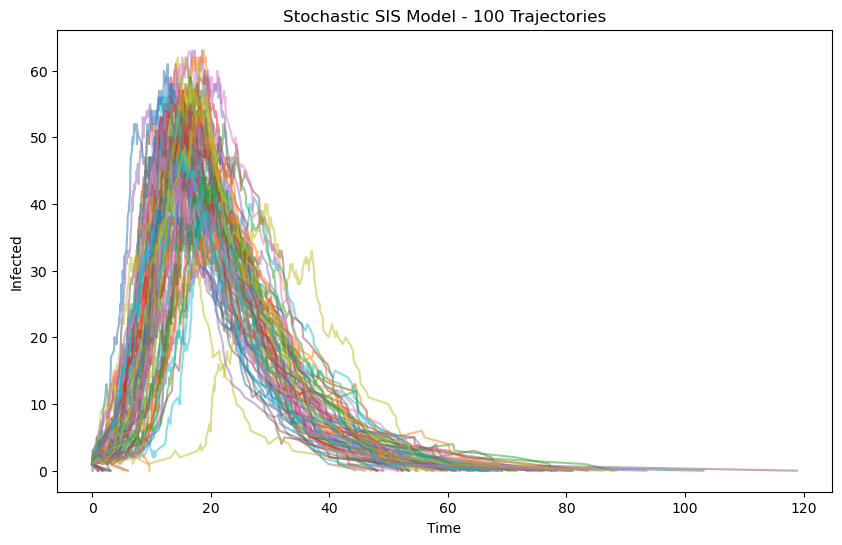

In [147]:
# SIS model parameters
beta = 0.5  # infection rate
gamma = 0.1  # recovery rate
kappa=100

# Initial conditions
initial_infected = 1
initial_susceptible = kappa-1
initial_state = [initial_susceptible, initial_infected]

# Number of trajectories to simulate
num_trajectories = 100

# Simulation parameters
max_time = 200
time_points = np.arange(0, max_time + 1, 1)

# Function to perform one trajectory simulation using Gillespie algorithm
def gillespie_sis_model(beta, gamma, initial_state, max_time):
    susceptible, infected = initial_state
    time = 0
    trajectory = [[time, susceptible, infected]]

    while time < max_time and infected > 0:
        rates = np.array([beta/kappa * susceptible * infected, gamma * infected])
        total_rate = sum(rates)

        if total_rate == 0:
            break  # No more possible events

        dt = np.random.exponential(1 / total_rate)
        event = np.random.choice(2, p=rates / total_rate)

        if event == 0:  # Infection event
            susceptible -= 1
            infected += 1
        elif event == 1:  # Recovery event
            infected -= 1

        time += dt
        trajectory.append([time, susceptible, infected])

    return np.array(trajectory)

# Simulate multiple trajectories
trajectories = []
for _ in range(num_trajectories):
    trajectory = gillespie_sis_model(beta, gamma, initial_state, max_time)
    trajectories.append(trajectory)

# Plot the trajectories
plt.figure(figsize=(10, 6))
for trajectory in trajectories:
    plt.plot(trajectory[:, 0], trajectory[:, 2], alpha=0.5)

plt.title('Stochastic SIS Model - 100 Trajectories')
plt.xlabel('Time')
plt.ylabel('Infected')
plt.show()


## SIR Model

$$
\frac{dP_{n,m}(t)}{dt}=-\left(\frac{\beta}{\kappa} nm +\gamma m\right)P_{n,m}(t)+\frac{\beta}{\kappa} (n+1)(m-1)P_{n+1,m-1}+\gamma (m+1) P_{n,m+1} 
$$

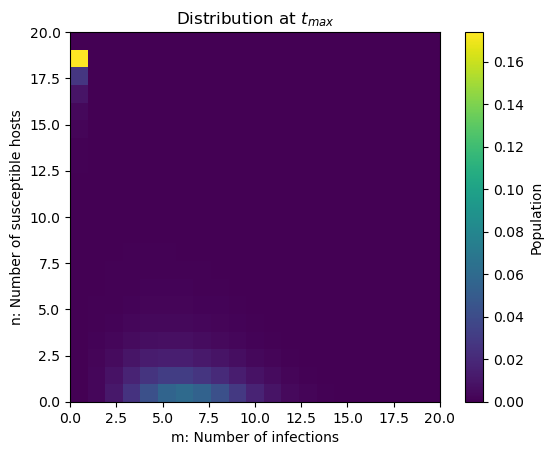

In [173]:
import numpy as np
from scipy.integrate import odeint

# System of ODEs
def model(Pin, t, beta, gamma, kappa,PShape):
    P=Pin.reshape(PShape)
    n_max, m_max = P.shape
    dPdt = np.zeros_like(P)

    for n in range(n_max):
        for m in range(m_max):
            dPdt[n, m] = -((beta / kappa) * n * m + gamma * m) * P[n, m]

            if n + 1 < n_max and m>0:
                dPdt[n, m] += (beta / kappa) * (n + 1) * (m - 1) * P[n + 1, m - 1]

            if m + 1 < m_max:
                dPdt[n, m] += gamma * (m + 1) * P[n, m + 1]

    return dPdt.ravel()

# Parameters
beta = 0.5
gamma = 0.1
kappa = 20

# Initial conditions (P_0,0 = 1, other elements are 0)
P0 = np.zeros((21, 21))
PShape=P0.shape
P0[kappa-1, 1] = 1.0

# Time points for integration
t = np.linspace(0, 20, 500)

# Numerical integration using odeint
P_result = odeint(model, P0.ravel(), t, args=(beta, gamma, kappa,PShape))

# Reshape the result back to a 2D array
P_result = P_result.reshape((len(t), 21, 21))

# Plotting the results (you can customize the plot according to your needs)
import matplotlib.pyplot as plt

plt.imshow(P_result[-1], cmap='viridis', origin='lower', extent=[0, 20, 0, 20])
plt.colorbar(label='Population')
plt.title('Distribution at $t_{max}$')
plt.xlabel('m: Number of infections')
plt.ylabel('n: Number of susceptible hosts')
plt.show()


This is a bit hard to interpret so let's  extract the "average number" of infections at time t.  To do this, take the average of m by summing over the elements of the matrix:
$\sum_{n,m}mP_{n,m}$

In [175]:
mAvg=np.array([np.sum(np.arange(P_result[t].shape[1]) * P_result[t]) for t in range(500)])

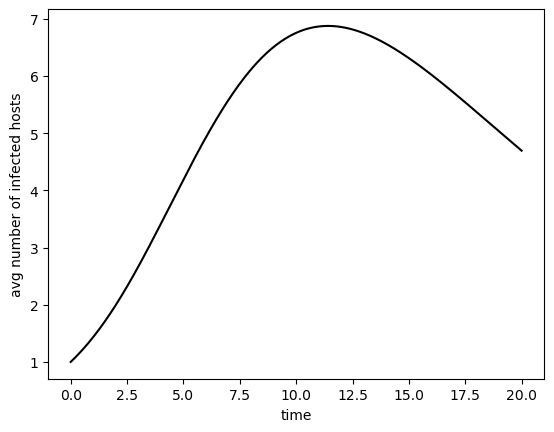

In [179]:
plt.plot(t,mAvg,color='black')
plt.xlabel('time')
plt.ylabel('avg number of infected hosts')
plt.show()

Or we can look at the first column of the matrix to understand the conditions of the system when the disease goes extinct.

In [186]:
P_result[-1][:,0]

array([0.00045798, 0.00050944, 0.00042541, 0.00033792, 0.00027527,
       0.00023673, 0.00021734, 0.00021376, 0.00022516, 0.00025359,
       0.00030474, 0.00039018, 0.00053232, 0.00077609, 0.00121819,
       0.00208895, 0.00401792, 0.00910845, 0.02730043, 0.17391128,
       0.        ])

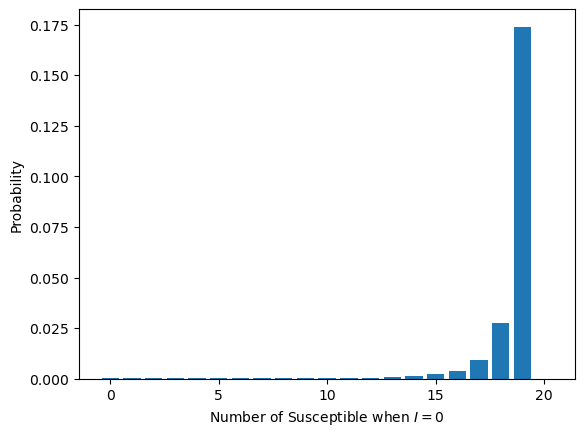

In [194]:
plt.bar(np.arange(len(P_result[-1][:,0])), P_result[-1][:,0])
plt.xlabel('Number of Susceptible when $I=0$')
plt.ylabel('Probability')
plt.show()